In [2]:
import numpy as np
import glob
import torch
from tqdm import tqdm
# import sigpy as sp
import matplotlib.pyplot as plt
import os
import argparse
from utils import nrmse, ifft, fft
from sampling_funcs import StackedRandomGenerator, simple_ODE_ps, general_SDE_ps
import pickle
import dnnlib
from torch_utils import distributed as dist
from skimage.metrics import structural_similarity as ssim
import random
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [3]:
# set random seeds
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
device=torch.device('cuda')

## Load Data and Generate Subsampled kspace

In [46]:
# load data (NOTE: this is single coil data artificially generated from Multicoil data with thresholded sensitivity maps)
data_file = 'test_data.pt'
cont = torch.load(data_file)
gt_img = cont['gt_img'].to(device)
ksp_fs = cont['ksp'].to(device)
maps = torch.ones_like(ksp_fs)

In [12]:
# undersample kspace
def sampling_mask_gen(ACS_perc, R, img_sz):
    ACS = int(ACS_perc*img_sz)
    outer_line_count = int(int(img_sz/R) - ACS)
    mask = np.zeros((img_sz,img_sz))
    # use 14 lines for center of ksp
    ACS_start = int(img_sz/2)-int(ACS/2)
    ACS_end = ACS_start + ACS
    center_idx = np.arange(ACS_start,ACS_end) # ACS_perc*img_sz central lines for ACS
    total_idx = np.arange(img_sz)
    rem_lines = np.delete(total_idx, center_idx)

    random.shuffle(rem_lines)
    mask_lines=np.concatenate((center_idx,rem_lines[0:outer_line_count]))


    # print(mask_lines)
    mask[:,mask_lines] = 1

    mask_batched = mask[None,None]

    return mask_batched

(-0.5, 255.5, 255.5, -0.5)

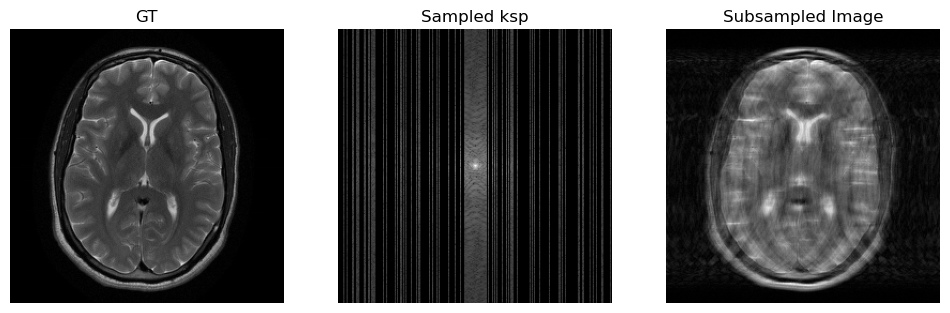

In [55]:
# generate sampling mask
ACS_perc = 0.08
R = 3
img_sz = ksp_fs.shape[-1]
mask = torch.tensor(sampling_mask_gen(ACS_perc, R, img_sz))
mask = mask.to(device)
ksp_us = ksp_fs*mask

us_recon = ifft(ksp_us)
norm_const = torch.max(abs(us_recon))
# norm_const = torch.max(abs(gt_img))

y_meas = ksp_us/norm_const
norm_gt_img = gt_img/norm_const


plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('GT')
plt.imshow(np.flipud(abs(gt_img[0,0]).cpu()),cmap = 'gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Sampled ksp')
plt.imshow(np.flipud(abs(ksp_us[0,0]**.2).cpu()),cmap = 'gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Subsampled Image')
plt.imshow(np.flipud(abs(us_recon[0,0]).cpu()),cmap = 'gray')
plt.axis('off')

## Set Inference Parameters

In [56]:
l_ss           = 1 # liklihood step size
sigma_max      = 10 # largest noise level to start at
num_steps      = 300 # number of inference steps to use
discretization = 'edm' # ['vp', 've', 'iddpm', 'edm'] type of time step disctretization to use when solving reverse SDE
solver         = 'euler' # ['euler', 'heun'] type of SDE solver to use (this should always be euler for now)
schedule       = 'vp' # ['vp', 've', 'linear'] this designates the type of noise level scaling schedule used
scaling        = 'vp' # ['vp', 'none'] this determines the type of scaling used on the underlying image

## load network

In [57]:
# replace this with your saved network
net_save = '/csiNAS2/slow/brett/edm_outputs/00037-fastmri_brain_preprocessed_9_25_23-uncond-ddpmpp-edm-gpus4-batch40-fp32-aspect/network-snapshot-004800.pkl'

if dist.get_rank() != 0:
        torch.distributed.barrier()

# Load network.
dist.print0(f'Loading network from "{net_save}"...')
with dnnlib.util.open_url(net_save, verbose=(dist.get_rank() == 0)) as f:
    net = pickle.load(f)['ema'].to(device)

Loading network from "/csiNAS2/slow/brett/edm_outputs/00037-fastmri_brain_preprocessed_9_25_23-uncond-ddpmpp-edm-gpus4-batch40-fp32-aspect/network-snapshot-004800.pkl"...


In [58]:
# create initialization vector for diffusion process.
batch_size = 1
rnd = StackedRandomGenerator(device, [seed])
latents = rnd.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)
class_labels = None

## Do Posterior Sampling

In [59]:
image_recon = general_SDE_ps(y=y_meas, mask=mask, maps=torch.ones_like(y_meas), l_ss=l_ss, 
    net=net, latents=latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=num_steps, sigma_min=0.002, sigma_max=sigma_max, rho=7,
    solver=solver, discretization=discretization, schedule='linear', scaling=scaling,
    epsilon_s=1e-3, C_1=0.001, C_2=0.008, M=1000, alpha=1,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, gt_img=norm_gt_img, verbose = True)
    
cplx_recon = torch.view_as_complex(image_recon.permute(0,-2,-1,1).contiguous())[None] #shape: [1,1,H,W]
cplx_recon = cplx_recon*norm_const

Step:0 ,  NRMSE: 4.649
Step:1 ,  NRMSE: 4.518
Step:2 ,  NRMSE: 4.400
Step:3 ,  NRMSE: 4.294
Step:4 ,  NRMSE: 4.202
Step:5 ,  NRMSE: 4.124
Step:6 ,  NRMSE: 4.058
Step:7 ,  NRMSE: 4.006
Step:8 ,  NRMSE: 3.968
Step:9 ,  NRMSE: 3.942
Step:10 ,  NRMSE: 3.929
Step:11 ,  NRMSE: 3.927
Step:12 ,  NRMSE: 3.926
Step:13 ,  NRMSE: 3.924
Step:14 ,  NRMSE: 3.923
Step:15 ,  NRMSE: 3.920
Step:16 ,  NRMSE: 3.921
Step:17 ,  NRMSE: 3.916
Step:18 ,  NRMSE: 3.918
Step:19 ,  NRMSE: 3.911
Step:20 ,  NRMSE: 3.916
Step:21 ,  NRMSE: 3.905
Step:22 ,  NRMSE: 3.914
Step:23 ,  NRMSE: 3.898
Step:24 ,  NRMSE: 3.912
Step:25 ,  NRMSE: 3.892
Step:26 ,  NRMSE: 3.908
Step:27 ,  NRMSE: 3.887
Step:28 ,  NRMSE: 3.901
Step:29 ,  NRMSE: 3.885
Step:30 ,  NRMSE: 3.895
Step:31 ,  NRMSE: 3.884
Step:32 ,  NRMSE: 3.888
Step:33 ,  NRMSE: 3.885
Step:34 ,  NRMSE: 3.882
Step:35 ,  NRMSE: 3.885
Step:36 ,  NRMSE: 3.876
Step:37 ,  NRMSE: 3.881
Step:38 ,  NRMSE: 3.870
Step:39 ,  NRMSE: 3.874
Step:40 ,  NRMSE: 3.864
Step:41 ,  NRMSE: 3.867
St

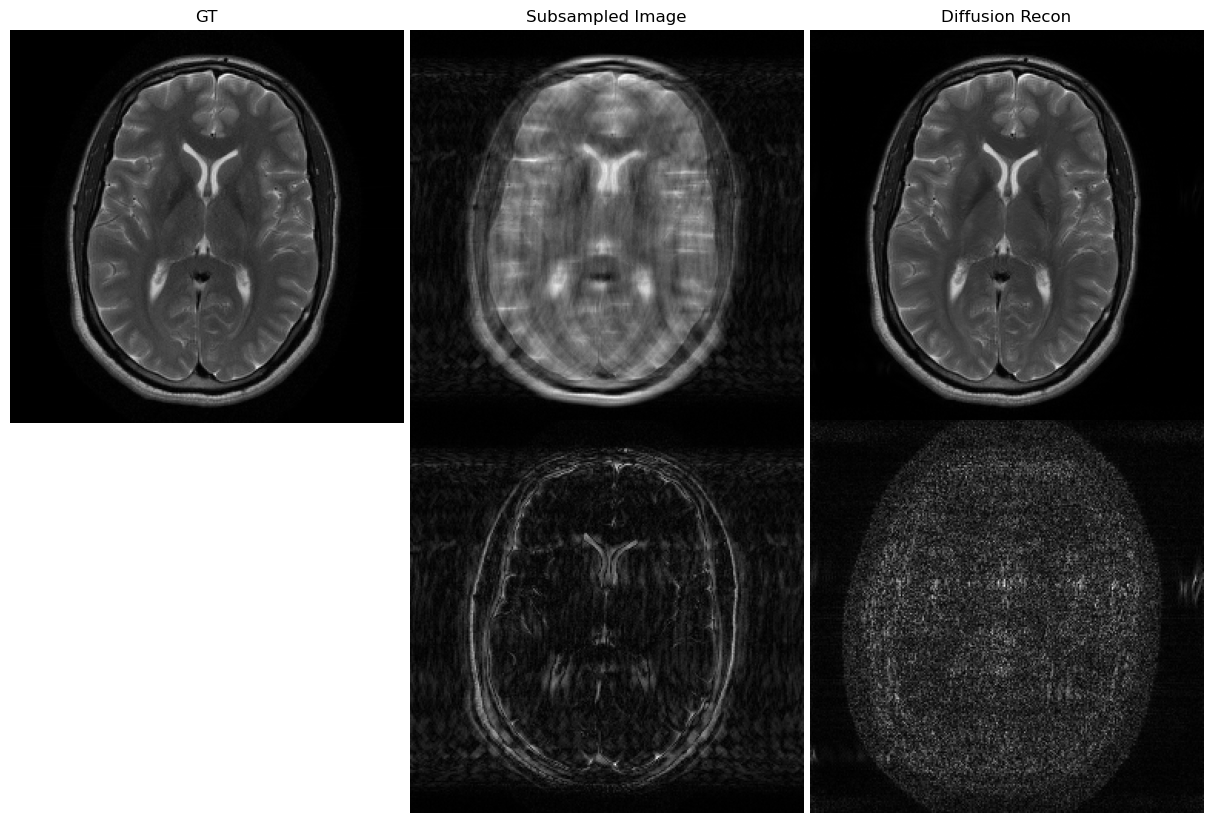

In [60]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.title('GT')
plt.imshow(np.flipud(abs(norm_gt_img[0,0]).cpu()),cmap = 'gray')
plt.axis('off')
plt.subplot(2,3,2)
plt.title('Subsampled Image')
plt.imshow(np.flipud(abs(us_recon[0,0]).cpu()),cmap = 'gray')
plt.axis('off')
plt.subplot(2,3,3)
plt.title('Diffusion Recon')
plt.imshow(np.flipud(abs(cplx_recon[0,0]).cpu()),cmap = 'gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(np.flipud(abs(gt_img[0,0]-us_recon[0,0]).cpu()),cmap = 'gray')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(np.flipud(abs(gt_img[0,0]-cplx_recon[0,0]).cpu()),cmap = 'gray')
plt.axis('off')

plt.tight_layout(pad=0.0)